<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/comparative-object-permanence/blob/measurement-layout/analysis/measurement-layouts/object_permanence_measurement_layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Object Permanence Measurement Layouts

Authors: K. Voudouris, J. Burden, J. Hernández-Orallo

## INIT

In [1]:
!pip install pymc --quiet
!pip install numpy --quiet
!pip install arviz --quiet
!pip install erroranalysis --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.3 MB/s eta 0:00:00


In [2]:
import arviz as az
import erroranalysis as ea
import gc
import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import random as rm
import seaborn as sns

from IPython.display import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from google.colab import files

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


## Load Data

In [3]:
agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_agents_wide.csv?token=GHSAT0AAAAAACEGARGREAIM5HWQB2NCVERMZHE2ZHQ'
agent_data = pd.read_csv(agents_url)

children_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_final_clean_children_wide.csv?token=GHSAT0AAAAAACEGARGR5NVKAZ3BKZDK6JQKZHE2ZQA'
children_data = pd.read_csv(children_url)

synthetic_agents_url = 'https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/comparative-object-permanence/measurement-layout/analysis/measurement-layouts/results_synthetic_agents_wide.csv?token=GHSAT0AAAAAACEGARGQJ5H5WHGOKSDKY3IKZHE2Z2A'
synthetic_agents_data = pd.read_csv(synthetic_agents_url)


## Define the Measurement Layout

In [105]:
## Helper functions

def logistic(x, L=1, k=1, x_0=0):
  return (L / (1 + np.exp(-k * (x-x_0))))

def logistic999(x, min, max):    # This logistic function ensures that if x is at -(max-min), we get prob 0.001, and if x is at (max-min), we get prob 0.999
  x = x - min
  max = max - min
  x = 6.90675478 * x / max
  return 1 / (1 + np.exp(-x))

def visualAcuityLOMargin(ability, goalSmallness): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  return ability - goalSmallness   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

#def flatNavMargin(ability, distanceToGoal, numTurns, allocentricOcclusion): # must return a value between -inf and inf  (more precisely between -maxSpatialAbility and maxSpatialAbility)
def flatNavMargin(ability, distanceToGoal, numTurns):
  #return ability - ((distanceToGoal * numTurns)*allocentricOcclusion)   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success
  return ability - ((distanceToGoal * numTurns))

def objPermanenceLOMargin(ability, allocentricOcclusion, cvChickP, pctbP, lightsOut, distanceToGoal, numPositions, maxPermAbility, lightsOutPenalisation, uniformAbilitySlack): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
#def objPermanenceLOMargin(ability, allocentricOcclusion, lightsOut, distanceToGoal, numPositions, maxPermAbility, lightsOutPenalisation, uniformAbilitySlack):
  assert lightsOutPenalisation < uniformAbilitySlack and lightsOutPenalisation > 1, "Penalisation for lights out must be lower than the slack on abilities."
  OPPerformance = ability  - ((distanceToGoal * numPositions)*(lightsOut*lightsOutPenalisation)) #this returns a value that is lower when (a) ability is lower, (b) the goal is occluded for longer or there are more positions where it could be occluded, or (c) when the lights go out (by a small penalisation)
  ability = maxPermAbility - ((maxPermAbility-OPPerformance)*allocentricOcclusion) * cvChickP * pctbP # this returns an ability value that is modulated by performance on the different paradigms. The agent needs to be good at both to have a high OP ability
  #return maxPermAbility-((maxPermAbility-OPPerformance)*((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb))) #multiply by a factor that introduces whether the instance is a an OP CV task or an OP PCTB task (independent, so ((allocentricOcclusion*cvChick) + (allocentricOcclusion*pctb)) should be 0 or 1)
  #return maxPermAbility - ((maxPermAbility-OPPerformance)*allocentricOcclusion)
  return ability

def scaledBeta(name, a, b, min, max, simpleGraph = True):
  if (simpleGraph):
    beta = pm.Beta(name, a, b)
    return beta * (max - min) + min
  else:
    beta = pm.Beta(f"{name}_raw", a, b)
    return pm.Deterministic(name, beta * (max - min) + min)


In [5]:
def SetupModel(taskResultsAll, uniformAbilitySlack, agent_type, agent_name = None, sample = 500):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """
  assert uniformAbilitySlack >=1, "Slack must be greater than or equal to 1."

  if agent_type == "agent":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults[agent_name]
  elif agent_type == "child":
    taskResults = taskResultsAll.dropna(subset = ['success'])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults['success']
  else:
    print("Agent not recognised. Quitting.")
    return



  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = taskResults["cityBlockDistanceToGoal"].max()
  maxTurns = taskResults["minNumTurnsRequired"].max()
  maxChoices = taskResults["numChoices"].max()
  maxGoalSize = taskResults["mainGoalSize"].max()
  maxPermAbility = maxDistance * maxChoices * uniformAbilitySlack
  #maxMemoryAbility = maxDistance * uniformAbilitySlack
  m = pm.Model()
  with m:

    objPermAbility = pm.Uniform("objPermAbility", 0, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = 0
    abilityMax["objPermAbility"] = maxPermAbility

    #memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    #abilityMin["memoryAbility"] = 0
    #abilityMax["memoryAbility"] = maxMemoryAbility

    #Visual acuity
    maxVisualAcuityAbility = maxGoalSize* uniformAbilitySlack
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", 0, maxVisualAcuityAbility)
    abilityMin["visualAcuityAbility"] = 0
    abilityMax["visualAcuityAbility"] = maxVisualAcuityAbility

    # Flat Navigation Ability
    flatNavAbility = pm.Uniform("flatNavAbility", 0, maxDistance*maxTurns)      # how much navigation is involved, i.e, how far away and how circuitous is the path to the goal?
    abilityMin["flatNavAbility"] =0
    abilityMax["flatNavAbility"] = maxDistance*maxTurns

    # Lava Ability
    lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1

    # Ramp Ability
    rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    abilityMin["rampAbility"] = 0
    abilityMax["rampAbility"] = 1

    # Goal Right Ability
    rightAbility = pm.Beta("rightAbility", 1, 1)
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 1

    # Goal Left Ability
    leftAbility = pm.Beta("leftAbility", 1, 1)
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 1

    # Goal Ahead Ability
    aheadAbility = pm.Beta("aheadAbility", 1, 1)
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 1

    # CV Chick Ability
    CVChickAbility = pm.Beta("CVChickAbility", 1, 1)
    abilityMin["CVChickAbility"] = 0
    abilityMax["CVChickAbility"] = 1

    # PCTB Ability
    PCTBAbility = pm.Beta("PCTBAbility", 1, 1)
    abilityMin["PCTBAbility"] = 0
    abilityMax["PCTBAbility"] = 1



    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values)
    rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values)
    #numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values)
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values)
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values)
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"])
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"])
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"])
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"])
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"])
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"])
    CVTest = pm.MutableData("CVChickTest", taskResults["cvchickTask"])
    PCTBTest = pm.MutableData("PCTBTest", taskResults["pctbTask"])

    ## Margins

    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSmallness)))

    rightP = pm.Deterministic("rightPerformance", SimplePrMargin(rightAbility, goalRight))
    aheadP = pm.Deterministic("aheadPerformance", SimplePrMargin(aheadAbility, goalAhead))
    leftP = pm.Deterministic("leftPerformance", SimplePrMargin(leftAbility, goalLeft))

    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns, opTest)))
    flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns)))

    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))

    rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    cvchickP = pm.Deterministic("cvChickP", SimplePrMargin(CVChickAbility, CVTest))
    pctbP = pm.Deterministic("pctbP", SimplePrMargin(PCTBAbility, PCTBTest))

    navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP * cvchickP * pctbP)) #, visualAcuityP))

    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, CVTest, PCTBTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    OPLOM = objPermanenceLOMargin(objPermAbility, opTest, cvchickP, pctbP, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)

    objPermP = pm.Deterministic("objPermP", logistic(OPLOM))

    noise = 1 - np.mean(results)  # With this noise is complementary to result prior.
    noisePar = pm.Uniform("noisePar", 0, 1)
    finalP = pm.Deterministic("finalP", (1-noisePar)*(objPermP * navP * visualAcuityP)+(noisePar*noise))

    #finalP = pm.Deterministic("finalP", (objPermP * navP * visualAcuityP))

    taskPerformance = pm.Bernoulli("taskPerformance", finalP, observed=results)

  pm.model_graph.model_to_graphviz(m)

  return m, abilityMin, abilityMax

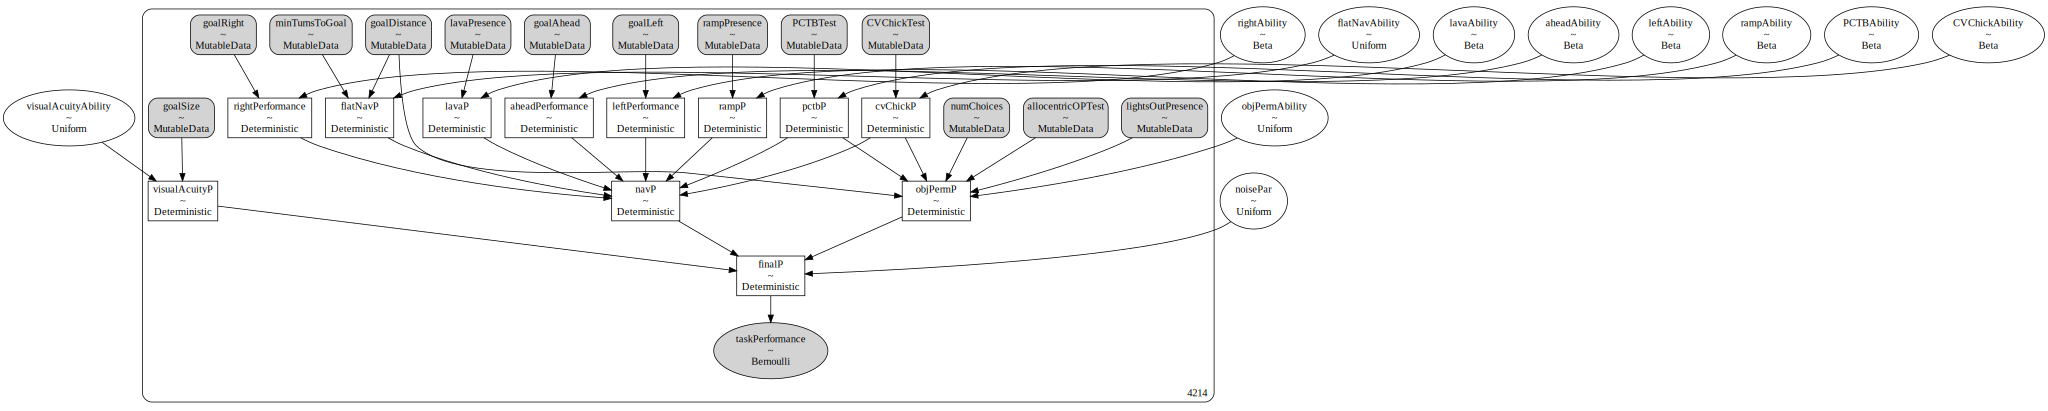

In [6]:
m, min, max = SetupModel(synthetic_agents_data, uniformAbilitySlack=1.4, agent_type='agent', agent_name="perfectAgent", sample = None)
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
#gv.render(directory='viz')
#Image("viz/Digraph.gv.png")
gv

In [242]:
def SetupModelSimple(taskResultsAll, uniformAbilitySlack, agent_type, agent_name = None, sample = 500):
  """
  taskResults is the conjunction of the metadata with the successes of the agents on that set of tests.
  """
  assert uniformAbilitySlack >=1, "Slack must be greater than or equal to 1."

  if agent_type == "agent":
    taskResults = taskResultsAll.dropna(subset = [agent_name])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults[agent_name]
  elif agent_type == "child":
    taskResults = taskResultsAll.dropna(subset = ['success'])
    if sample is not None:
      taskResults = taskResults.sample(n=sample)
    results = taskResults['success']
  else:
    print("Agent not recognised. Quitting.")
    return



  abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
  abilityMax = {}

  #Decide "maximum capabilities" based on the hardest values in the dataset
  maxDistance = taskResults["cityBlockDistanceToGoal"].max()
  maxTurns = taskResults["minNumTurnsRequired"].max()
  maxChoices = taskResults["numChoices"].max()
  maxGoalSize = taskResults["mainGoalSize"].max() * uniformAbilitySlack
  maxPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).max()) * uniformAbilitySlack
  maxFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).max() * uniformAbilitySlack
  #maxPermAbility = maxChoices * uniformAbilitySlack
  #maxMemoryAbility = maxDistance * uniformAbilitySlack
  #maxPermAbility = 1
  #maxMemoryAbility = 1

  # Decide 'minimum capabilities' based on easiest values in the dataset
  minDistance = taskResults["cityBlockDistanceToGoal"].min()
  minTurns = taskResults["minNumTurnsRequired"].min()
  minChoices = taskResults["numChoices"].min()
  minGoalSize = taskResults["mainGoalSize"].min() * (1-(uniformAbilitySlack-1))
  minPermAbility = ((taskResults["cityBlockDistanceToGoal"] * taskResults["numChoices"]).min()) * (1-(uniformAbilitySlack-1))
  minFlatNav = ((taskResults["cityBlockDistanceToGoal"]*taskResults["minNumTurnsRequired"])).min() * (1-(uniformAbilitySlack-1))
  #minPermAbility = 0

  m = pm.Model()
  with m:

    objPermAbility = pm.Uniform("objPermAbility", minPermAbility, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
    abilityMin["objPermAbility"] = minPermAbility
    abilityMax["objPermAbility"] = maxPermAbility

    #objPermAbility = scaledBeta("objPermAbility", 1,1, minPermAbility, maxPermAbility, simpleGraph=False)
    abilityMin["objPermAbility"] = minPermAbility
    abilityMax["objPermAbility"] = maxPermAbility

    #memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
    #abilityMin["memoryAbility"] = 0
    #abilityMax["memoryAbility"] = maxMemoryAbility

    #Visual acuity
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", minGoalSize, maxGoalSize)
    abilityMin["visualAcuityAbility"] = minGoalSize
    abilityMax["visualAcuityAbility"] = maxGoalSize

    # Flat Navigation Ability
    flatNavAbility = pm.Uniform("flatNavAbility", minFlatNav, maxFlatNav)      # how much navigation is involved, i.e, how far away and how circuitous is the path to the goal?
    #flatNavAbility = pm.Uniform("flatNavAbility", 0, maxTurns*maxDistance)
    abilityMin["flatNavAbility"] = minFlatNav
    #abilityMax["flatNavAbility"] = maxDistance*maxTurns
    abilityMax["flatNavAbility"] = maxFlatNav

    # Lava Ability
    lavaAbility = scaledBeta("lavaAbility", 1,1, 0, 2, simpleGraph=False)
    #lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 2

    # Ramp Ability
    #rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    #abilityMin["rampAbility"] = 0
    #abilityMax["rampAbility"] = 1

    # Goal Right Ability
    #rightAbility = pm.Beta("rightAbility", 1, 1)
    rightAbility = scaledBeta("rightAbility", 1,1, 0, 2, simpleGraph=False)
    abilityMin["rightAbility"] = 0
    abilityMax["rightAbility"] = 2

    # Goal Left Ability
    #leftAbility = pm.Beta("leftAbility", 1, 1)
    leftAbility = scaledBeta("leftAbility", 1,1, 0, 2, simpleGraph=False)
    abilityMin["leftAbility"] = 0
    abilityMax["leftAbility"] = 2

    # Goal Ahead Ability
    #aheadAbility = pm.Beta("aheadAbility", 1, 1)
    aheadAbility = scaledBeta("aheadAbility", 1,1, 0, 2, simpleGraph=False)
    abilityMin["aheadAbility"] = 0
    abilityMax["aheadAbility"] = 2

    # CV Chick Ability
    #CVChickAbility = pm.Beta("CVChickAbility", 1, 1)
    CVChickAbility = scaledBeta("CVChickAbility", 1,1, 0, 2, simpleGraph=False)
    abilityMin["CVChickAbility"] = 0
    abilityMax["CVChickAbility"] = 2

    # PCTB Ability
    #PCTBAbility = pm.Beta("PCTBAbility", 1, 1)
    PCTBAbility = scaledBeta("PCTBAbility", 1,1, 0, 2, simpleGraph=False)
    abilityMin["PCTBAbility"] = 0
    abilityMax["PCTBAbility"] = 2



    ## Environment variables as Deterministic (about the instance)

    lavaPresence = pm.MutableData("lavaPresence", taskResults["lavaPresence"].values)
    #rampPresence = pm.MutableData("rampPresence", taskResults["taskCriticalRampPresence"].values)
    #lightsOutPresence = pm.MutableData("lightsOutPresence", taskResults["lightsOutPresence"].values)
    #numGoals = pm.MutableData("numberOfGoals", taskResults["numGoalsAll"].values)
    numChoices = pm.MutableData("numChoices", taskResults["numChoices"].values)
    goalSize = pm.MutableData("goalSize",taskResults["mainGoalSize"].values)
    goalDist = pm.MutableData("goalDistance", taskResults["cityBlockDistanceToGoal"].values)
    numTurns = pm.MutableData("minTurnsToGoal", taskResults["minNumTurnsRequired"])
    goalRight = pm.MutableData("goalRight", taskResults["goalRightRelToStart"])
    goalAhead = pm.MutableData("goalAhead", taskResults["goalCentreRelToStart"])
    goalLeft = pm.MutableData("goalLeft", taskResults["goalLeftRelToStart"])
    opTest = pm.MutableData("allocentricOPTest", taskResults["goalBecomesAllocentricallyOccluded"].values)
    CVTest = pm.MutableData("CVChickTest", taskResults["cvchickTask"])
    PCTBTest = pm.MutableData("PCTBTest", taskResults["pctbTask"])

    ## Margins

    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic999(visualAcuityLOMargin(visualAcuityAbility, goalSmallness), min = minGoalSize, max = maxGoalSize))

    rightP = pm.Deterministic("rightPerformance", logistic999(SimplePrMargin(rightAbility, goalRight), min = 0, max = 2))
    aheadP = pm.Deterministic("aheadPerformance", logistic999(SimplePrMargin(aheadAbility, goalAhead), min = 0, max = 2))
    leftP = pm.Deterministic("leftPerformance", logistic999(SimplePrMargin(leftAbility, goalLeft), min = 0, max = 2))

    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns, opTest)))
    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavMargin(flatNavAbility, goalDist, numTurns)))
    #flatNavP = pm.Deterministic("flatNavP", logistic(flatNavAbility - (numTurns * goalDist)))
    flatNavP = pm.Deterministic("flatNavP", logistic999(flatNavAbility - (numTurns * goalDist), min = minFlatNav, max = maxFlatNav))

    lavaP = pm.Deterministic("lavaP", logistic999(SimplePrMargin(lavaAbility, lavaPresence), min = 0, max = 2))

    #rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence))

    cvchickP = pm.Deterministic("cvChickP", logistic999(SimplePrMargin(CVChickAbility, CVTest), min = 0, max = 2))
    pctbP = pm.Deterministic("pctbP", logistic999(SimplePrMargin(PCTBAbility, PCTBTest), min = 0, max = 2))

    #navP = pm.Deterministic("navP", (flatNavP * lavaP * rampP * rightP * aheadP * leftP * cvchickP * pctbP)) #, visualAcuityP))
    navP = pm.Deterministic("navP", (flatNavP * lavaP * rightP * aheadP * leftP))

    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, CVTest, PCTBTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)
    #OPLOM = objPermanenceLOMargin(objPermAbility, opTest, cvchickP, pctbP, lightsOutPresence, goalDist, numChoices, maxPermAbility, lightsOutPenalisation=(uniformAbilitySlack-0.35), uniformAbilitySlack=uniformAbilitySlack)

    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)*opTest)) #this returns a value that is lower when (a) ability is lower, (b) the goal is occluded for longer or there are more positions where it could be occluded, or (c) when the lights go out (by a small penalisation)
    #OPPerformance = (objPermAbility  - ((goalDist * numChoices)))
    #OPPerformance = (objPermAbility  - numChoices)
    #OPPerformance = (objPermAbility  - ((goalDist*opTest) * (numChoices*opTest)))
    #OPPerformance = objPermAbility  - ((goalDist * numChoices)*opTest)
    #OPability = maxPermAbility - ((maxPermAbility-OPPerformance)*opTest)
    #objPermP = pm.Deterministic("objPermP", logistic(OPLOM))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(SimplePrMargin(objPermAbility, opTest), x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    OPPerformance = (objPermAbility  - (((goalDist*opTest) * numChoices) + (numChoices * (1-opTest))))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance, x_0 = ((maxPermAbility - minPermAbility)/2)+minPermAbility))
    #objPermP = pm.Deterministic("objPermP", logistic(OPPerformance))
    objPermP = pm.Deterministic("objPermP", (logistic999(OPPerformance, min = minPermAbility, max = maxPermAbility) * cvchickP * pctbP))

    #flatNavP = pm.Deterministic("flatNavP", logistic((flatNavAbility - (numTurns * goalDist)), x_0 = ((maxFlatNav - minFlatNav)/2)+minFlatNav))
    #noise = 1 - np.mean(results)  # With this noise is complementary to result prior.
    #noisePar = pm.Uniform("noisePar", 0, 1)
    #finalP = pm.Deterministic("finalP", (1-noisePar)*(objPermP * navP * visualAcuityP)+(noisePar*noise))

    #finalP = pm.Deterministic("finalP", (objPermP * flatNavP))
    #finalP = pm.Deterministic("finalP", (1-((1-objPermP)*(1-flatNavP)))) #compensatory finalPerformance
    #finalP = pm.Deterministic("finalP", (objPermP * flatNavP * visualAcuityP))
    finalP = pm.Deterministic("finalP", (objPermP * navP * visualAcuityP))

    #taskPerformance = pm.Bernoulli("taskPerformance", flatNavP, observed=results)
    taskPerformance = pm.Bernoulli("taskPerformance", finalP, observed=results)
    #taskPerformance = pm.Bernoulli("taskPerformance", objPermP, observed=results)
  #pm.model_graph.model_to_graphviz(m)

  return m, abilityMin, abilityMax

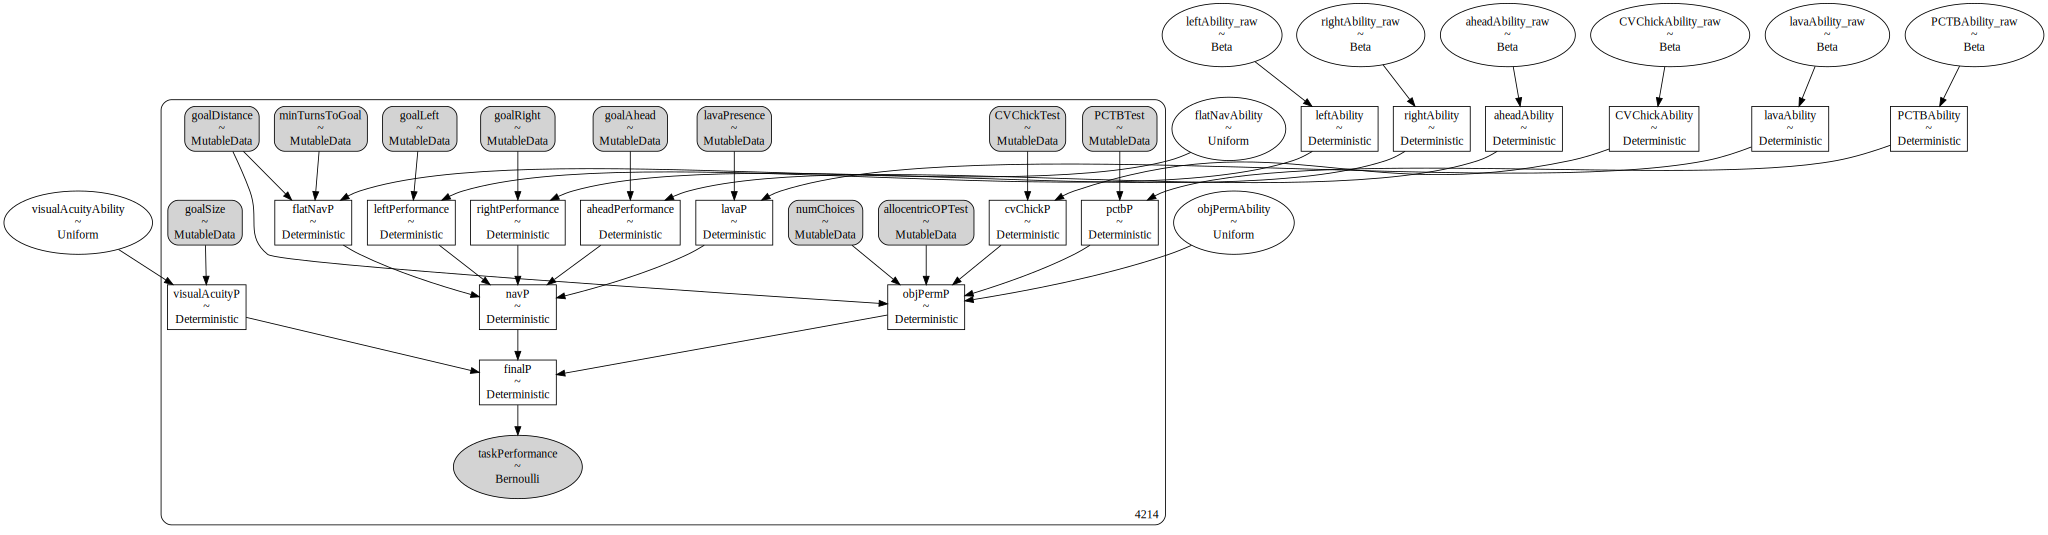

In [243]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1.4, agent_type='agent', agent_name="perfectAgent", sample = None)
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
#gv.render(directory='viz')
#Image("viz/Digraph.gv.png")
gv

In [184]:
# A function for pulling out the means and standard deviations for abilities of interest
def analyzeAgentResults(agentName, agentData, abilitiesToShow):

  abilityMeans = [] # empty list to add in ability means to
  abilitySDs = []
  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior

    posteriorMean = float(np.mean(agentData['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(agentData['posterior'][a])) #calculate posterior sd
    abilityMeans.append(posteriorMean)
    abilitySDs.append(posteriorSD)

  return abilityMeans, abilitySDs

# A function for padding the testing data with 0s for prediction
def pad(testingData, trainingDataSize):
    return testingData.append(pd.Series(np.zeros(trainingDataSize-len(testingData), dtype=int)))

# A function for making predictions based on a fitted measurement layout
def predict(m, agentData, dfTest, agent, len_training):
  with m:
    # set the data for prediction
    pm.set_data({"lavaPresence": pad(dfTest["lavaPresence"], len_training)})
    pm.set_data({"lightsOutPresence": pad(dfTest["lightsOutPresence"], len_training)})
    pm.set_data({"rampPresence": pad(dfTest["taskCriticalRampPresence"], len_training)})
    pm.set_data({"numChoices": pad(dfTest["numChoices"], len_training)})
    pm.set_data({"minTurnsToGoal": pad(dfTest["minNumTurnsRequired"], len_training)})
    pm.set_data({"goalDistance": pad(dfTest["cityBlockDistanceToGoal"], len_training)})
    pm.set_data({"goalSize": pad(dfTest["mainGoalSize"], len_training)})
    pm.set_data({"goalRight": pad(dfTest["goalRightRelToStart"], len_training)})
    pm.set_data({"goalAhead": pad(dfTest["goalCentreRelToStart"], len_training)})
    pm.set_data({"goalLeft": pad(dfTest["goalLeftRelToStart"], len_training)})
    pm.set_data({"CVChickTest": pad(dfTest["cvchickTask"], len_training)})
    pm.set_data({"PCTBTest": pad(dfTest["pctbTask"], len_training)})
    pm.set_data({"allocentricOPTest": pad(dfTest["goalBecomesAllocentricallyOccluded"], len_training)})

    predictions=pm.sample_posterior_predictive(agentData, var_names=["finalP"], return_inferencedata=False,predictions=True,extend_inferencedata=False)
    predictionChainRuns =predictions["finalP"][:,:,0:len(dfTest)]
    predictionsInstance = np.mean(predictionChainRuns, (0,1))

    return predictionsInstance,  dfTest[agent].to_numpy()


def brierScore(preds, outs):
    return 1/len(preds) * sum( (preds-outs)**2 )

def brierDecomp(preds, outs):

  brier= 1/len(preds) * sum( (preds-outs)**2 )
  ## bin predictions
  bins = np.linspace(0,1,11)
  binCenters = (bins[:-1] +bins[1:]) /2
  binPredInds = np.digitize(preds,binCenters)
  binnedPreds = bins[binPredInds]

  binTrueFreqs = np.zeros(10)
  binPredFreqs = np.zeros(10)
  binCounts = np.zeros(10)

  for i in range(10):
      idx = (preds >= bins[i]) & (preds < bins[i+1])

      binTrueFreqs[i] = np.sum(outs[idx])/np.sum(idx) if np.sum(idx) > 0 else 0
     # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
      binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
      binCounts[i] = np.sum(idx)

  calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(binCounts)>0 else 0
  refinement = np.sum(binCounts * (binTrueFreqs *(1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(binCounts)> 0 else 0
  # Compute refinement component
  #refinement = brier - calibration
  return brier, calibration, refinement



In [185]:
agents_training, agents_test = train_test_split(agent_data, test_size=0.2)
children_training, children_test = train_test_split(children_data, test_size=0.2)


In [245]:
m, min, max = SetupModelSimple(children_training, uniformAbilitySlack=1.1, agent_type='child', sample = None)

In [246]:
with m:
    childData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [244]:
#abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rampAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility", "noisePar"]
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility"]

m, min, max = SetupModelSimple(children_test, uniformAbilitySlack=1.1, agent_type='child', sample = None)

mu, sd  = analyzeAgentResults("children", childData, abilitiesToShow)
mean_success = np.mean(children_data['success'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)
#predictions, testOutputs = predict(m, childData, children_test, "success", len(children_training["success"]))

KeyError: ignored

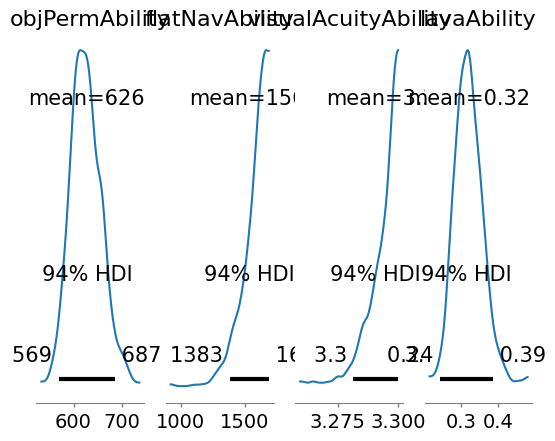

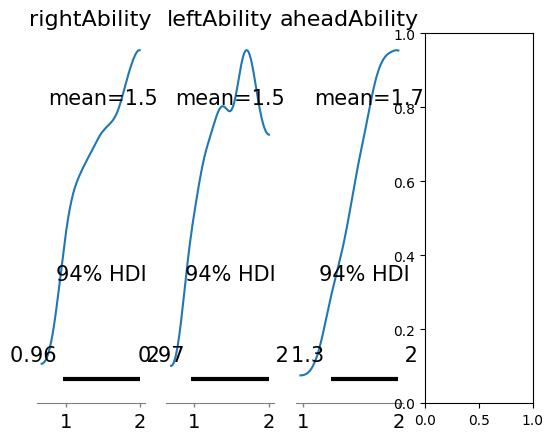

In [241]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig, (ax5, ax6, ax7, ax8) = plt.subplots(1,4)
fig, (ax9) = plt.subplots(1)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(childData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(childData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(childData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(childData["posterior"]["lavaAbility"], ax=ax4);
az.plot_posterior(childData["posterior"]["rightAbility"], ax=ax5);
az.plot_posterior(childData["posterior"]["leftAbility"], ax=ax6);
az.plot_posterior(childData["posterior"]["aheadAbility"], ax=ax7);
az.plot_posterior(childData["posterior"]["CVChickAbility"], ax=ax8);
az.plot_posterior(childData["posterior"]["PCTBAbility"], ax=ax9);
plt.show()

In [214]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1.1, agent_type='agent', agent_name="perfectAgent", sample = None)

In [215]:
with m:
    agentData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [216]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility"]
#abilitiesToShow = ["objPermAbility", "objPermP"]
mu, sd  = analyzeAgentResults("perfectAgent", agentData, abilitiesToShow)
mean_success = np.mean(synthetic_agents_data['perfectAgent'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)

1.0
[777.1175926882452, 5.498985703117423, 1682.197385257524, 1.9274249633407343]
[1.6560054779557318, 0.0009916087093768135, 5.260007726305457, 0.06194938838507036]
{'objPermAbility': 8.1, 'visualAcuityAbility': 0.44999999999999996, 'flatNavAbility': 0.0, 'lavaAbility': 0}
{'objPermAbility': 778.8000000000001, 'visualAcuityAbility': 5.5, 'flatNavAbility': 1687.4, 'lavaAbility': 2}


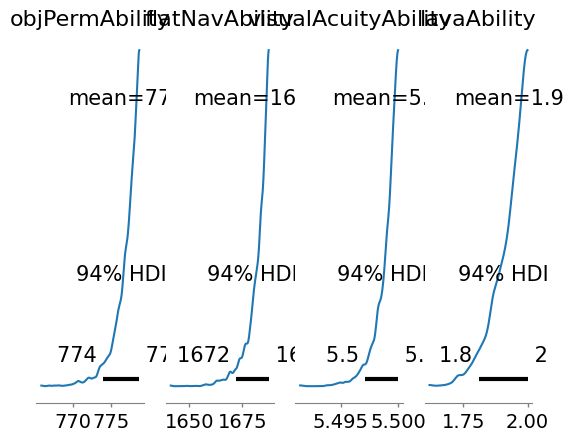

In [217]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(agentData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(agentData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(agentData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(agentData["posterior"]["lavaAbility"], ax=ax4);
plt.show()

In [218]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1, agent_type='agent', agent_name="failedAgent", sample = None)
with m:
    agentData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [219]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility"]
#abilitiesToShow = ["objPermAbility", "objPermP"]
mu, sd  = analyzeAgentResults("failedAgent", agentData, abilitiesToShow)
mean_success = np.mean(synthetic_agents_data['failedAgent'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)

0.0
[20.919592062480895, 0.5451610029713089, 24.277619954610838, 0.47059010580457605]
[12.294115969957758, 0.043798723343279, 23.997996177633873, 0.528760057042263]
{'objPermAbility': 9.0, 'visualAcuityAbility': 0.5, 'flatNavAbility': 0.0, 'lavaAbility': 0}
{'objPermAbility': 708.0, 'visualAcuityAbility': 5.0, 'flatNavAbility': 1534.0, 'lavaAbility': 2}


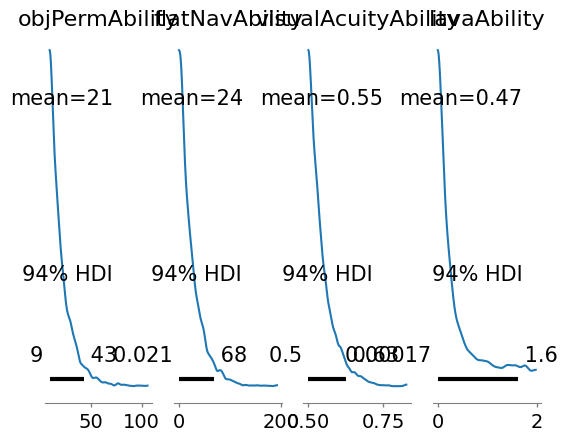

In [220]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(agentData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(agentData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(agentData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(agentData["posterior"]["lavaAbility"], ax=ax4);
plt.show()

In [221]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1, agent_type='agent', agent_name="noOPAgent", sample = None)
with m:
    agentData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [197]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility"]
mu, sd  = analyzeAgentResults("noOPAgent", agentData, abilitiesToShow)
mean_success = np.mean(synthetic_agents_data['noOPAgent'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)

0.565733270052207
[150.71678293378088, 4.996722271978831, 1424.5929695167952]
[4.301131930998153, 0.003258188018621785, 82.77062126123077]
{'objPermAbility': 9.0, 'visualAcuityAbility': 0.5, 'flatNavAbility': 0.0}
{'objPermAbility': 708.0, 'visualAcuityAbility': 5.0, 'flatNavAbility': 1534.0}


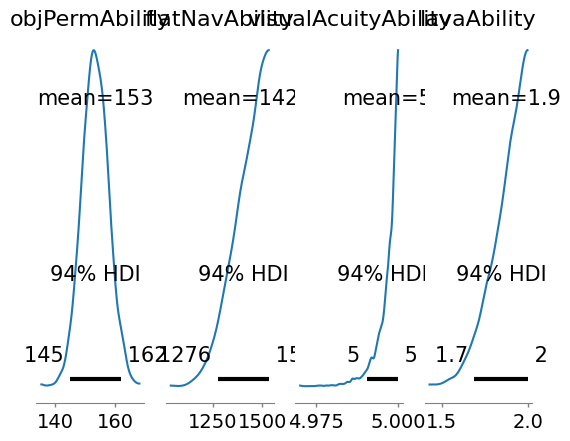

In [222]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(agentData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(agentData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(agentData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(agentData["posterior"]["lavaAbility"], ax=ax4);
plt.show()

In [225]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1, agent_type='agent', agent_name="poorNavigationOPAgent", sample = None)
with m:
    agentData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [228]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility"]
mu, sd  = analyzeAgentResults("poorNavigationOPAgent", agentData, abilitiesToShow)
mean_success = np.mean(synthetic_agents_data['poorNavigationOPAgent'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)

0.18889416231608921
[95.7493117942114, 4.984050087245154, 246.97115478786367, 0.001934826378711214]
[11.630073112045938, 0.015553283558223196, 29.07964316528771, 0.0018652984981691026]
{'objPermAbility': 9.0, 'visualAcuityAbility': 0.5, 'flatNavAbility': 0.0, 'lavaAbility': 0}
{'objPermAbility': 708.0, 'visualAcuityAbility': 5.0, 'flatNavAbility': 1534.0, 'lavaAbility': 2}


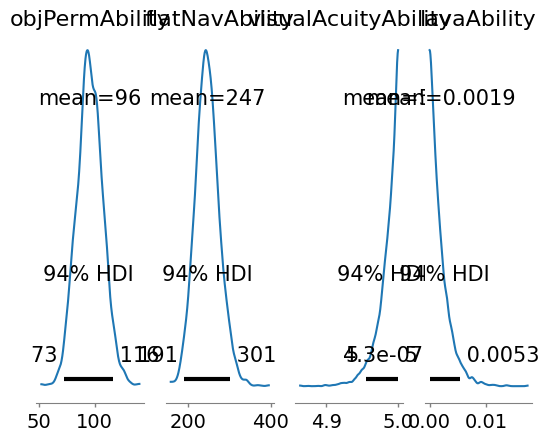

In [229]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(agentData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(agentData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(agentData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(agentData["posterior"]["lavaAbility"], ax=ax4);
plt.show()

In [230]:
m, min, max = SetupModelSimple(synthetic_agents_data, uniformAbilitySlack=1, agent_type='agent', agent_name="lowVisualAcuityAgent", sample = None)
with m:
    agentData = pm.sample(2000, target_accept=0.95) #Might need more samples to converge

In [231]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility"]
mu, sd  = analyzeAgentResults("lowVisualAcuityAgent", agentData, abilitiesToShow)
mean_success = np.mean(synthetic_agents_data['lowVisualAcuityAgent'])
print(mean_success)
print(mu)
print(sd)
print(min)
print(max)

0.5813953488372093
[705.1752136233672, 3.8986090756876277, 1525.9048469658844, 1.8687675276243576]
[2.7612490516653803, 0.02457869136219144, 7.861526033225514, 0.10652918412704811]
{'objPermAbility': 9.0, 'visualAcuityAbility': 0.5, 'flatNavAbility': 0.0, 'lavaAbility': 0}
{'objPermAbility': 708.0, 'visualAcuityAbility': 5.0, 'flatNavAbility': 1534.0, 'lavaAbility': 2}


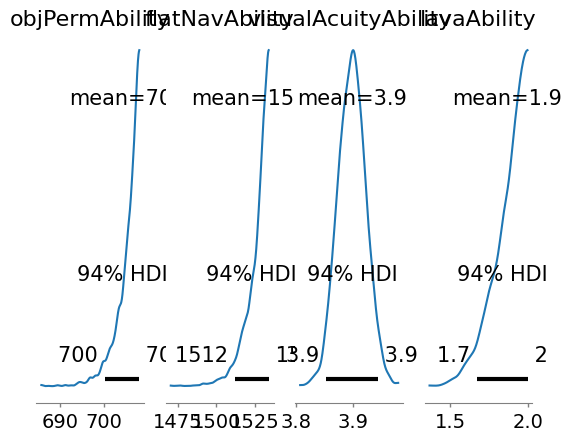

In [232]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig, (ax1) = plt.subplots(1)
az.plot_posterior(agentData["posterior"]["objPermAbility"], ax=ax1);
az.plot_posterior(agentData["posterior"]["flatNavAbility"], ax=ax2);
az.plot_posterior(agentData["posterior"]["visualAcuityAbility"], ax=ax3);
az.plot_posterior(agentData["posterior"]["lavaAbility"], ax=ax4);
plt.show()

--------------------------------------------------------------------------------


Excess Code

In [ ]:
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rampAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility", "noisePar"]
mu, sd  = analyzeAgentResults("perfectAgent", agentData, abilitiesToShow)
print(mu)
print(sd)
print(max)

In [ ]:
agentName = "Vanilla_Braitenberg_15_rays_over_60_degs_3761"
abilitiesToShow = ["objPermAbility", "visualAcuityAbility", "flatNavAbility", "lavaAbility", "rampAbility", "rightAbility", "leftAbility", "aheadAbility", "CVChickAbility", "PCTBAbility", "noisePar"]

m, min, max = SetupModel(agents_test, uniformAbilitySlack=1.4, agent_type='agent', agent_name=agentName)

mu, sd  = analyzeAgentResults(agentName, agentData, abilitiesToShow)
print(mu)
print(sd)
#predictions, testOutputs = predict(m, agentData, agents_test, agentName, len(agents_training[agentName]))

In [ ]:

abilityDF = pd.DataFrame( {'Ability': abilitiesIncludingSuccess})
meansDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
stdDevDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
modelBrierScores = []
aggregateBrierScores = []
modelCalibrations = []
aggregateCalibrations = []
modelRefinements = []
aggregateRefinements = []

agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(agent_data[agentName]), len(testOutputs)), testOutputs)
aggregateBrierScores.append(agentAggBrierScore)
aggregateCalibrations.append(agentAggCalibration)
aggregateRefinements.append(agentAggRefinement)
modelBrierScores.append(agentBrierScore)
modelCalibrations.append(agentCalibration)
modelRefinements.append(agentRefinement)
abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]

In [ ]:
agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]
print(agentBrierScore)
print(agentCalibration)
print(agentRefinement)
print(abilityMeans)
print(abilitySDs)

In [ ]:
brier= 1/len(predictions) * sum( (predictions-testOutputs)**2 )
print(sum( (predictions-testOutputs)**2))
# ## bin predictions
# bins = np.linspace(0,1,11)
# binCenters = (bins[:-1] +bins[1:]) /2
# binPredInds = np.digitize(preds,binCenters)
# binnedPreds = bins[binPredInds]
# binTrueFreqs = np.zeros(10)
# binPredFreqs = np.zeros(10)
# binCounts = np.zeros(10)
# for i in range(10):
#   idx = (preds >= bins[i]) & (preds < bins[i+1])

#   binTrueFreqs[i] = np.sum(outs[idx])/np.sum(idx) if np.sum(idx) > 0 else 0
#   # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
#   binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
#   binCounts[i] = np.sum(idx)

# calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(binCounts)>0 else 0
# refinement = np.sum(binCounts * (binTrueFreqs *(1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(binCounts)> 0 else 0
# # Compute refinement component
# #refinement = brier - calibration



In [ ]:
brierDF = pd.DataFrame({"Model Brier Score":modelBrierScores, "Aggregate Brier Scores": aggregateBrierScores, "Model Calibration": modelCalibrations, "Aggregate Calibration":aggregateCalibrations, "Model Refinement":modelRefinements, "Aggregate Refinement":aggregateRefinements,  "Model Better? (Based on Brier Score)":np.array(modelBrierScores)<np.array(aggregateBrierScores), "Success Score":meansDF.iloc[9][1:]})

In [ ]:
taskResults = agent_data[agentName] #Grab the column of results for that agent
print(agent_data)
print(np.mean(taskResults)) #print mean performance for the agent across all tasks
m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults

mu, sd  = analyzeAgentResults(agentName, agentData)
predictions, testOutputs = predict(m, agentData, agents_test[agentName], len(agents_test[agentName]))
agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(taskResults), len(testOutputs)), testOutputs)
aggregateBrierScores.append(agentAggBrierScore)
aggregateCalibrations.append(agentAggCalibration)
aggregateRefinements.append(agentAggRefinement)
modelBrierScores.append(agentBrierScore)
modelCalibrations.append(agentCalibration)
modelRefinements.append(agentRefinement)
abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]

In [ ]:
mu

In [ ]:
sd

In [ ]:
max

In [ ]:
##### Sample results for each agent using the model defined in the function above.
allAgentData = [] #blank list for entering the outputs of the pm sampling for each agent
agentNames = [] #blank list for the agent names
agentColList = agentCols.tolist()
print(agentColList)
numAgents = len(agentColList) #Number of agents, replace with a small number for testing to save time
print(numAgents)
#numAgents=3
abilitiesToShow = ["objPermAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "platformAbility", "rampAbility", "memoryAbility", "rightLeftBias", "noisePar"]

abilitiesIncludingSuccess = abilitiesToShow + ["Success"]
abilityDF = pd.DataFrame( {'Ability': abilitiesIncludingSuccess})
meansDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
stdDevDF = pd.DataFrame({"Ability": abilitiesIncludingSuccess})
modelBrierScores = []
aggregateBrierScores = []
modelCalibrations = []
aggregateCalibrations = []
modelRefinements = []
aggregateRefinements = []


for i in range(numAgents): # Iterate through each agent.
  agent = agentCols[i] #Get the agent name
  taskResults = df[agent] #Grab the column of results for that agent
  print(agent)
  print(np.mean(taskResults)) #print mean performance for the agent across all tasks
  m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults

  #Now sample based on this agent's performance
  with m:
    agentData = pm.sample(1000, target_accept=0.95) #Might need more samples to converge

  mu, sd  = analyzeAgentResults(agent, agentData)
  predictions, testOutputs = predict(m, agentData, dfTest, agent)
  agentBrierScore, agentCalibration, agentRefinement = brierDecomp(predictions, testOutputs)
  agentAggBrierScore, agentAggCalibration, agentAggRefinement = brierDecomp(np.repeat(np.mean(taskResults), len(testOutputs)), testOutputs)
  aggregateBrierScores.append(agentAggBrierScore)
  aggregateCalibrations.append(agentAggCalibration)
  aggregateRefinements.append(agentAggRefinement)
  modelBrierScores.append(agentBrierScore)
  modelCalibrations.append(agentCalibration)
  modelRefinements.append(agentRefinement)
  abilityMeans= [str(round(mu_i, 2))+" " for mu_i in mu]  # add ability mean estimate to list for this agent
  abilitySDs = [""+str(round(sd_i,2)) for sd_i in sd ]


  abilityMeans = abilityMeans + [str(round(np.mean(taskResults),2))+" "]
  abilitySDs = abilitySDs + [str(round(np.std(taskResults), 2))]
  abilityDF[agent] = list(zip(abilityMeans, abilitySDs))
  mu=mu+[np.mean(taskResults)]
  sd=sd+[np.std(taskResults)]
  meansDF[agent]=[round(mu_i,2) for mu_i in mu]
  stdDevDF[agent]=[round(sd_i,2) for sd_i in sd]